estoy haciendo este hackaton:
🌐 Antecedentes
El desafío de la contaminación energética y la acción climática surge de la dependencia global de los combustibles fósiles, principales responsables de las emisiones de gases de efecto invernadero. La combustión de carbón, petróleo y gas natural para la producción de energía libera dióxido de carbono y otros contaminantes nocivos a la atmósfera, lo que acelera el cambio climático y daña los ecosistemas. A medida que aumenta la demanda de energía debido al crecimiento demográfico y al desarrollo industrial, el impacto ambiental se intensifica. Este desafío requiere soluciones innovadoras para la transición hacia fuentes de energía más limpias, mejorar la eficiencia energética e implementar prácticas sostenibles. Combatir la contaminación energética es vital no solo para mitigar el cambio climático, sino también para promover comunidades más saludables y garantizar la sostenibilidad ambiental a largo plazo.

con los siguientes datasets:
Index(['Measurement date', 'Station code', 'Latitude', 'Longitude', 'SO2',
       'NO2', 'O3', 'CO', 'PM10', 'PM2.5'],
      dtype='object') dataset: data
Index(['Measurement date', 'Station code', 'Latitude', 'Longitude', 'SO2',
       'NO2', 'O3', 'CO', 'PM10', 'PM2.5'],
      dtype='object') dataset: instrument
Index(['Measurement date', 'Station code', 'Latitude', 'Longitude', 'SO2',
       'NO2', 'O3', 'CO', 'PM10', 'PM2.5'],
      dtype='object') dataset: pollutant

este es el enunciado de la segunda tarea:
Task 2: Develop the forecasting model :
Predict hourly pollutant concentrations for the following stations and periods, assuming error-free measurements:

Station code: 206 | pollutant: SO2   | Period: 2023-07-01 00:00:00 - 2023-07-31 23:00:00
Station code: 211 | pollutant: NO2   | Period: 2023-08-01 00:00:00 - 2023-08-31 23:00:00
Station code: 217 | pollutant: O3    | Period: 2023-09-01 00:00:00 - 2023-09-30 23:00:00
Station code: 219 | pollutant: CO    | Period: 2023-10-01 00:00:00 - 2023-10-31 23:00:00
Station code: 225 | pollutant: PM10  | Period: 2023-11-01 00:00:00 - 2023-11-30 23:00:00
Station code: 228 | pollutant: PM2.5 | Period: 2023-12-01 00:00:00 - 2023-12-31 23:00:00
Expected output format:

{
  "target":
  {
    "206": 
      {
        "2023-07-01 00:00:00": 0.32,
        "2023-07-01 01:00:00": 0.5,
        "2023-07-01 02:00:00": 0.8,
        "2023-07-01 03:00:00": 0.11,
        "2023-07-01 04:00:00": 0.7,
        ...
      },
    "211":
      {
        ...
      }
  }
}

y ya tengo un código que cumple con los requisitos:

In [7]:
import pandas as pd

data = pd.read_csv("data/raw/measurement_data.csv")
instrument = pd.read_csv("data/raw/measurement_data.csv")
pollutant = pd.read_csv("data/raw/measurement_data.csv")

print(data.columns,"dataset: data")
print(instrument.columns,"dataset: instrument")
print(pollutant.columns,"dataset: pollutant")

Index(['Measurement date', 'Station code', 'Latitude', 'Longitude', 'SO2',
       'NO2', 'O3', 'CO', 'PM10', 'PM2.5'],
      dtype='object') dataset: data
Index(['Measurement date', 'Station code', 'Latitude', 'Longitude', 'SO2',
       'NO2', 'O3', 'CO', 'PM10', 'PM2.5'],
      dtype='object') dataset: instrument
Index(['Measurement date', 'Station code', 'Latitude', 'Longitude', 'SO2',
       'NO2', 'O3', 'CO', 'PM10', 'PM2.5'],
      dtype='object') dataset: pollutant


# 329/550

R² para estación 225 y contaminante PM10: 0.1580
Predicciones guardadas en predictions/predictions_task_2.json


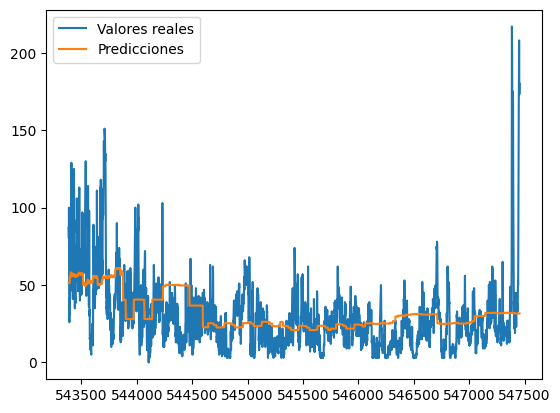

In [61]:
import pandas as pd
import json
import pickle
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Cargar los datos
data = pd.read_csv("data/raw/measurement_data.csv")

# Convertir la columna de fecha a tipo datetime
data['Measurement date'] = pd.to_datetime(data['Measurement date'])

# Extraer características temporales
data["hour"] = data["Measurement date"].dt.hour
data["month"] = data["Measurement date"].dt.month
data["weekday"] = data["Measurement date"].dt.weekday
data["is_weekend"] = data["weekday"].isin([5, 6]).astype(int)

# Filtro para la estación y contaminante PM10
station_code = "225"
pollutant = "PM10"

# Filtrar los datos para la estación y contaminante
station_data = data[(data['Station code'] == int(station_code)) & (data[pollutant] >= 0)].copy()

if station_data.empty:
    print(f"No hay datos suficientes para la estación {station_code} y contaminante {pollutant}")

# Eliminar valores atípicos (outliers) de PM10
# Usamos un rango entre 0 y 600 µg/m³ basado en los valores típicos de la tabla proporcionada
station_data = station_data[(station_data[pollutant] >= 0) & (station_data[pollutant] <= 600)]

# Extraer características temporales
station_data['day'] = station_data['Measurement date'].dt.day

# Definir X (características) y y (target)
X = station_data[['hour', 'day', 'weekday', 'month']]
y = station_data[pollutant]

# Normalizar los datos de entrada para mejorar la convergencia del modelo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División de datos en series temporales
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Crear el modelo
model = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Calcular R2
r2 = r2_score(y_test, y_pred)
print(f'R² para estación {station_code} y contaminante {pollutant}: {r2:.4f}')

# Predicción para el período solicitado
start_date = '2023-11-01 00:00:00'
end_date = '2023-11-30 23:00:00'
period_start = pd.to_datetime(start_date)
period_end = pd.to_datetime(end_date)
date_range = pd.date_range(start=period_start, end=period_end, freq='h')

# Crear DataFrame con características temporales para predicción
forecast_data = pd.DataFrame({'Measurement date': date_range})
forecast_data['hour'] = forecast_data['Measurement date'].dt.hour
forecast_data['day'] = forecast_data['Measurement date'].dt.day
forecast_data['weekday'] = forecast_data['Measurement date'].dt.weekday
forecast_data['month'] = forecast_data['Measurement date'].dt.month

# Normalizar los datos de predicción
forecast_data_scaled = scaler.transform(forecast_data[['hour', 'day', 'weekday', 'month']])

# Generar predicciones
predictions = model.predict(forecast_data_scaled)

# Guardar las predicciones en el diccionario de salida
output = {"target": {}}
output["target"][station_code] = dict(zip(forecast_data['Measurement date'].astype(str), predictions))

# Guardar el modelo entrenado
model_filename = f"models/model_task_2_station_{station_code}.pkl"
os.makedirs(os.path.dirname(model_filename), exist_ok=True)
with open(model_filename, 'wb') as f:
    pickle.dump(model, f)

# Guardar las predicciones en un archivo JSON
output_filename = "predictions/predictions_task_2.json"
os.makedirs(os.path.dirname(output_filename), exist_ok=True)
with open(output_filename, 'w') as f:
    json.dump(output, f, indent=4)

# Imprimir el resultado
print(f"Predicciones guardadas en {output_filename}")

# Comparar predicciones y valores reales (si tienes los datos reales)
import matplotlib.pyplot as plt
plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, y_pred, label='Predicciones')
plt.legend()
plt.show()


R² para PM2.5: 0.2531


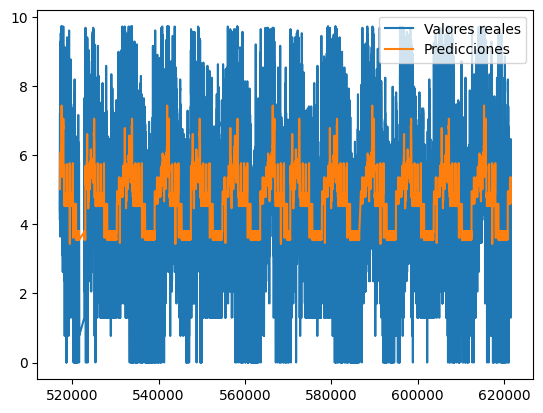

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv("data/raw/measurement_data.csv")

# Convertir la columna de fecha a tipo datetime
data['Measurement date'] = pd.to_datetime(data['Measurement date'])

# Filtrar los datos para PM2.5
pollutant = "PM2.5"
station_data = data[(data[pollutant] >= 0)].copy()

# Eliminar outliers utilizando percentiles (por ejemplo, 1% y 99% percentil)
lower_percentile = station_data[pollutant].quantile(0.01)
upper_percentile = station_data[pollutant].quantile(0.99)
station_data = station_data[(station_data[pollutant] >= lower_percentile) & (station_data[pollutant] <= upper_percentile)]

# Aplicar transformación Box-Cox para PM2.5 (para hacer los datos más normales)
station_data[pollutant] = station_data[pollutant] + 0.001  # Añadir un valor pequeño para evitar ceros
station_data[pollutant], lambda_value = stats.boxcox(station_data[pollutant])

# Extraer características temporales
station_data['hour'] = station_data['Measurement date'].dt.hour
station_data['month'] = station_data['Measurement date'].dt.month
station_data['weekday'] = station_data['Measurement date'].dt.weekday
station_data['day'] = station_data['Measurement date'].dt.day

# Definir X (características) y y (target)
X = station_data[['hour', 'day', 'weekday', 'month']]
y = station_data[pollutant]

# Normalizar los datos de entrada para mejorar la convergencia del modelo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División de datos en series temporales
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Crear el modelo
model = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Calcular R2
r2 = r2_score(y_test, y_pred)
print(f'R² para PM2.5: {r2:.4f}')

# Comparar predicciones y valores reales
plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, y_pred, label='Predicciones')
plt.legend()
plt.show()


R² para PM2.5: 0.2531


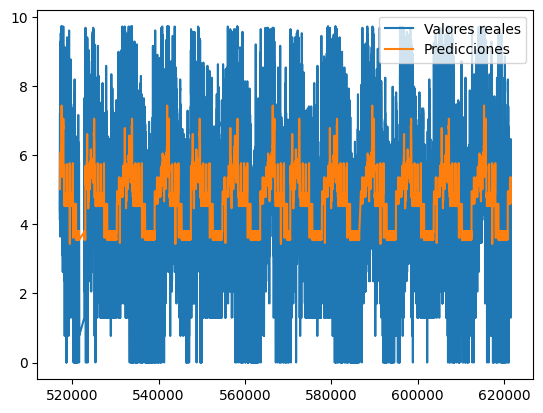

In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv("data/raw/measurement_data.csv")

# Convertir la columna de fecha a tipo datetime
data['Measurement date'] = pd.to_datetime(data['Measurement date'])

# Filtrar los datos para PM2.5
pollutant = "PM2.5"
station_data = data[(data[pollutant] >= 0)].copy()

# Eliminar outliers utilizando percentiles (por ejemplo, 1% y 99% percentil)
lower_percentile = station_data[pollutant].quantile(0.01)
upper_percentile = station_data[pollutant].quantile(0.99)
station_data = station_data[(station_data[pollutant] >= lower_percentile) & (station_data[pollutant] <= upper_percentile)]

# Aplicar transformación Box-Cox para PM2.5 (para hacer los datos más normales)
station_data[pollutant] = station_data[pollutant] + 0.001  # Añadir un valor pequeño para evitar ceros
station_data[pollutant], lambda_value = stats.boxcox(station_data[pollutant])

# Extraer características temporales
station_data['hour'] = station_data['Measurement date'].dt.hour
station_data['month'] = station_data['Measurement date'].dt.month
station_data['weekday'] = station_data['Measurement date'].dt.weekday
station_data['day'] = station_data['Measurement date'].dt.day

# Definir X (características) y y (target)
X = station_data[['hour', 'day', 'weekday', 'month']]
y = station_data[pollutant]

# Normalizar los datos de entrada para mejorar la convergencia del modelo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Aplicamos el fit_transform solo una vez, en los datos de entrenamiento

# División de datos en series temporales
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Crear el modelo
model = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Calcular R2
r2 = r2_score(y_test, y_pred)
print(f'R² para PM2.5: {r2:.4f}')

# Comparar predicciones y valores reales
plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, y_pred, label='Predicciones')
plt.legend()
plt.show()


Datos cargados en 0.60 segundos
Fecha convertida en 0.47 segundos
Filtrado de datos en 0.07 segundos
Eliminación de outliers en 0.05 segundos
Transformación Box-Cox en 4.28 segundos
Características temporales extraídas en 0.17 segundos
Normalización en 0.07 segundos
División en series temporales en 0.09 segundos
Entrenamiento del modelo en 22.85 segundos
Predicciones realizadas en 0.19 segundos
R² para PM2.5: 0.2531


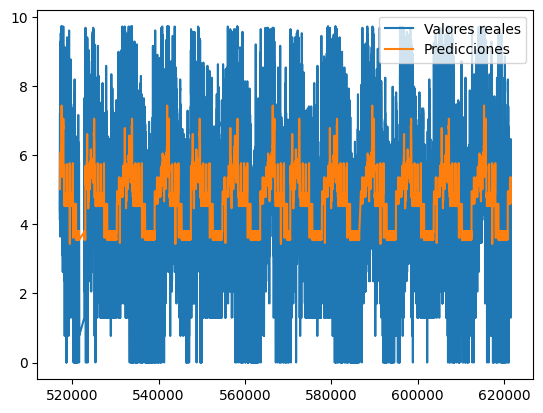

In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import time

# Cargar los datos
start_time = time.time()
data = pd.read_csv("data/raw/measurement_data.csv")
print(f"Datos cargados en {time.time() - start_time:.2f} segundos")

# Convertir la columna de fecha a tipo datetime
start_time = time.time()
data['Measurement date'] = pd.to_datetime(data['Measurement date'])
print(f"Fecha convertida en {time.time() - start_time:.2f} segundos")

# Filtrar los datos para PM2.5
pollutant = "PM2.5"
start_time = time.time()
station_data = data[(data[pollutant] >= 0)].copy()
print(f"Filtrado de datos en {time.time() - start_time:.2f} segundos")

# Eliminar outliers utilizando percentiles
start_time = time.time()
lower_percentile = station_data[pollutant].quantile(0.01)
upper_percentile = station_data[pollutant].quantile(0.99)
station_data = station_data[(station_data[pollutant] >= lower_percentile) & (station_data[pollutant] <= upper_percentile)]
print(f"Eliminación de outliers en {time.time() - start_time:.2f} segundos")

# Aplicar transformación Box-Cox para PM2.5
start_time = time.time()
station_data[pollutant] = station_data[pollutant] + 0.001  # Añadir un valor pequeño para evitar ceros
station_data[pollutant], lambda_value = stats.boxcox(station_data[pollutant])
print(f"Transformación Box-Cox en {time.time() - start_time:.2f} segundos")

# Extraer características temporales
start_time = time.time()
station_data['hour'] = station_data['Measurement date'].dt.hour
station_data['month'] = station_data['Measurement date'].dt.month
station_data['weekday'] = station_data['Measurement date'].dt.weekday
station_data['day'] = station_data['Measurement date'].dt.day
print(f"Características temporales extraídas en {time.time() - start_time:.2f} segundos")

# Definir X (características) y y (target)
X = station_data[['hour', 'day', 'weekday', 'month']]
y = station_data[pollutant]

# Normalizar los datos de entrada
start_time = time.time()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Normalización en {time.time() - start_time:.2f} segundos")

# División de datos en series temporales
start_time = time.time()
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
print(f"División en series temporales en {time.time() - start_time:.2f} segundos")

# Crear el modelo
model = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)

# Entrenar el modelo
start_time = time.time()
model.fit(X_train, y_train)
print(f"Entrenamiento del modelo en {time.time() - start_time:.2f} segundos")

# Hacer predicciones
start_time = time.time()
y_pred = model.predict(X_test)
print(f"Predicciones realizadas en {time.time() - start_time:.2f} segundos")

# Calcular R2
r2 = r2_score(y_test, y_pred)
print(f'R² para PM2.5: {r2:.4f}')

# Comparar predicciones y valores reales
plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, y_pred, label='Predicciones')
plt.legend()
plt.show()


R² para estación 206 y contaminante SO2: -0.2530
R² para estación 211 y contaminante NO2: 0.3100
R² para estación 217 y contaminante O3: 0.3723
R² para estación 219 y contaminante CO: -0.0383
R² para estación 225 y contaminante PM10: -0.5646
R² para estación 228 y contaminante PM2.5: -0.0186
Predicciones guardadas en predictions/predictions_task_2.json


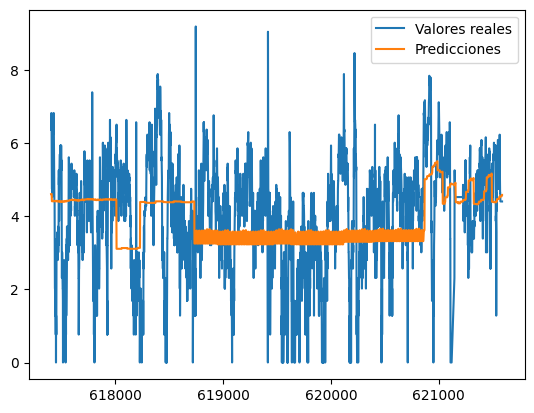

In [93]:
import pandas as pd
import json
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
import numpy as np

# Cargar los datos
data = pd.read_csv("data/raw/measurement_data.csv")

# Convertir la columna de fecha a tipo datetime
data['Measurement date'] = pd.to_datetime(data['Measurement date'])

# Extraer características temporales
data["hour"] = data["Measurement date"].dt.hour
data["month"] = data["Measurement date"].dt.month
data["weekday"] = data["Measurement date"].dt.weekday
data["is_weekend"] = data["weekday"].isin([5, 6]).astype(int)

# Definir las estaciones y los contaminantes
stations = {
    "206": ("SO2", '2023-07-01 00:00:00', '2023-07-31 23:00:00'),
    "211": ("NO2", '2023-08-01 00:00:00', '2023-08-31 23:00:00'),
    "217": ("O3", '2023-09-01 00:00:00', '2023-09-30 23:00:00'),
    "219": ("CO", '2023-10-01 00:00:00', '2023-10-31 23:00:00'),
    "225": ("PM10", '2023-11-01 00:00:00', '2023-11-30 23:00:00'),
    "228": ("PM2.5", '2023-12-01 00:00:00', '2023-12-31 23:00:00')
}

# Inicializar el diccionario de resultados
output = {"target": {}}

# Iterar sobre cada estación y contaminante
# Iterar sobre cada estación y contaminante
for station_code, (pollutant, start_date, end_date) in stations.items():
    # Filtrar los datos para la estación y contaminante
    station_data = data[(data['Station code'] == int(station_code)) & (data[pollutant] >= 0)].copy()

    if station_data.empty:
        print(f"No hay datos suficientes para la estación {station_code} y contaminante {pollutant}")
        continue

    # Aplicar eliminación de outliers si es PM2.5
    if pollutant == "PM2.5":
        lower_percentile = station_data[pollutant].quantile(0.01)
        upper_percentile = station_data[pollutant].quantile(0.99)
        station_data = station_data[(station_data[pollutant] >= lower_percentile) & (station_data[pollutant] <= upper_percentile)]

        # Aplicar transformación Box-Cox
        station_data[pollutant] = station_data[pollutant] + 0.001  # Evitar valores 0
        station_data[pollutant], lambda_value = stats.boxcox(station_data[pollutant])

    # Extraer características temporales
    station_data['day'] = station_data['Measurement date'].dt.day

    # Definir X (características) y y (target)
    X = station_data[['hour', 'day', 'weekday', 'month']]
    y = station_data[pollutant]

    # Normalizar los datos de entrada
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # División de datos en series temporales
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Crear y entrenar el modelo
    model = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test)

    # Calcular R2
    r2 = r2_score(y_test, y_pred)
    print(f'R² para estación {station_code} y contaminante {pollutant}: {r2:.4f}')


    # Predicción para el período solicitado
    period_start = pd.to_datetime(start_date)
    period_end = pd.to_datetime(end_date)
    date_range = pd.date_range(start=period_start, end=period_end, freq='h')

    # Crear DataFrame con características temporales para predicción
    forecast_data = pd.DataFrame({'Measurement date': date_range})
    forecast_data['hour'] = forecast_data['Measurement date'].dt.hour
    forecast_data['day'] = forecast_data['Measurement date'].dt.day
    forecast_data['weekday'] = forecast_data['Measurement date'].dt.weekday
    forecast_data['month'] = forecast_data['Measurement date'].dt.month

    # Normalizar los datos de predicción
    forecast_data_scaled = scaler.transform(forecast_data[['hour', 'day', 'weekday', 'month']])

    # Generar predicciones
    predictions = model.predict(forecast_data_scaled)

    # Guardar las predicciones en el diccionario de salida
    output["target"][station_code] = dict(zip(forecast_data['Measurement date'].astype(str), predictions))

# Guardar las predicciones en un archivo JSON
output_filename = "predictions/predictions_task_2.json"
os.makedirs(os.path.dirname(output_filename), exist_ok=True)
with open(output_filename, 'w') as f:
    json.dump(output, f, indent=4)

# Imprimir el resultado
print(f"Predicciones guardadas en {output_filename}")

# Comparar predicciones y valores reales (si tienes los datos reales)
import matplotlib.pyplot as plt
plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, y_pred, label='Predicciones')
plt.legend()
plt.show()


R² para estación 206 y contaminante SO2: -0.2530
R² para estación 211 y contaminante NO2: 0.3100
R² para estación 217 y contaminante O3: 0.3723
R² para estación 219 y contaminante CO: -0.0383
R² para estación 225 y contaminante PM10: 0.1580
R² para estación 228 y contaminante PM2.5: -0.0111
Predicciones guardadas en predictions/predictions_task_2.json


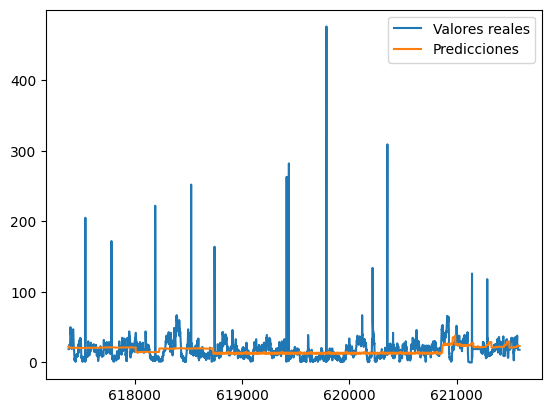

In [10]:
import pandas as pd
import json
import pickle
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Cargar los datos
data = pd.read_csv("data/raw/measurement_data.csv")

# Convertir la columna de fecha a tipo datetime
data['Measurement date'] = pd.to_datetime(data['Measurement date'])

# Extraer características temporales
data["hour"] = data["Measurement date"].dt.hour
data["month"] = data["Measurement date"].dt.month
data["weekday"] = data["Measurement date"].dt.weekday
data["is_weekend"] = data["weekday"].isin([5, 6]).astype(int)

# Definir las estaciones y los contaminantes
stations = {
    "206": ("SO2", '2023-07-01 00:00:00', '2023-07-31 23:00:00'),
    "211": ("NO2", '2023-08-01 00:00:00', '2023-08-31 23:00:00'),
    "217": ("O3", '2023-09-01 00:00:00', '2023-09-30 23:00:00'),
    "219": ("CO", '2023-10-01 00:00:00', '2023-10-31 23:00:00'),
    "225": ("PM10", '2023-11-01 00:00:00', '2023-11-30 23:00:00'),
    "228": ("PM2.5", '2023-12-01 00:00:00', '2023-12-31 23:00:00')
}

# Inicializar el diccionario de resultados
output = {"target": {}}

# Iterar sobre cada estación y contaminante
for station_code, (pollutant, start_date, end_date) in stations.items():
    # Filtrar los datos para la estación y contaminante
    station_data = data[(data['Station code'] == int(station_code)) & (data[pollutant] >= 0)].copy()

    if station_data.empty:
        print(f"No hay datos suficientes para la estación {station_code} y contaminante {pollutant}")
        continue

    # Eliminar valores atípicos (outliers) de PM10 (solo para esta estación)
    if pollutant == "PM10":
        station_data = station_data[(station_data[pollutant] >= 0) & (station_data[pollutant] <= 600)]

    # Extraer características temporales
    station_data['day'] = station_data['Measurement date'].dt.day

    # Definir X (características) y y (target)
    X = station_data[['hour', 'day', 'weekday', 'month']]
    y = station_data[pollutant]

    # Normalizar los datos de entrada para mejorar la convergencia del modelo
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # División de datos en series temporales
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Crear el modelo
    model = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test)

    # Calcular R2
    r2 = r2_score(y_test, y_pred)
    print(f'R² para estación {station_code} y contaminante {pollutant}: {r2:.4f}')

    # Predicción para el período solicitado
    period_start = pd.to_datetime(start_date)
    period_end = pd.to_datetime(end_date)
    date_range = pd.date_range(start=period_start, end=period_end, freq='h')

    # Crear DataFrame con características temporales para predicción
    forecast_data = pd.DataFrame({'Measurement date': date_range})
    forecast_data['hour'] = forecast_data['Measurement date'].dt.hour
    forecast_data['day'] = forecast_data['Measurement date'].dt.day
    forecast_data['weekday'] = forecast_data['Measurement date'].dt.weekday
    forecast_data['month'] = forecast_data['Measurement date'].dt.month

    # Normalizar los datos de predicción
    forecast_data_scaled = scaler.transform(forecast_data[['hour', 'day', 'weekday', 'month']])

    # Generar predicciones
    predictions = model.predict(forecast_data_scaled)

    # Guardar las predicciones en el diccionario de salida
    output["target"][station_code] = dict(zip(forecast_data['Measurement date'].astype(str), predictions))


# Guardar las predicciones en un archivo JSON
output_filename = "predictions/predictions_task_2.json"
os.makedirs(os.path.dirname(output_filename), exist_ok=True)
with open(output_filename, 'w') as f:
    json.dump(output, f, indent=4)

# Imprimir el resultado
print(f"Predicciones guardadas en {output_filename}")

# Comparar predicciones y valores reales (si tienes los datos reales)
import matplotlib.pyplot as plt
plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, y_pred, label='Predicciones')
plt.legend()
plt.show()


In [75]:
print(station_data["PM2.5"].describe())

count    25145.000000
mean        24.508173
std         21.531232
min          0.000000
25%         12.000000
50%         20.000000
75%         31.000000
max        610.000000
Name: PM2.5, dtype: float64


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² para estación 206 y contaminante SO2: -0.0922
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² para estación 211 y contaminante NO2: 0.0619
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² para estación 217 y contaminante O3: 0.1347
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² para estación 219 y contaminante CO: -0.1011
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² para estación 225 y contaminante PM10: 0.2141
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² para estación 228 y contaminante PM2.5: 0.0063
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
Predicciones guardadas en predictions/predictions_task_2.json


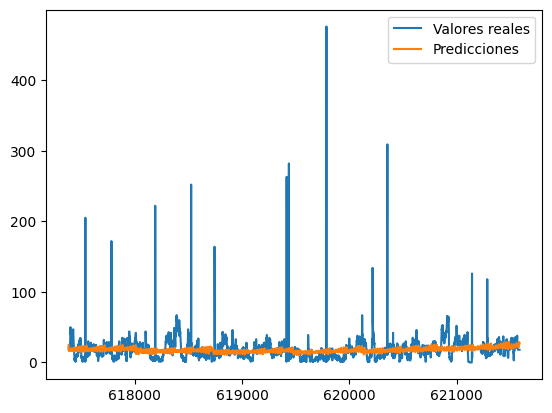

In [3]:
import pandas as pd
import json
import pickle
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv("data/raw/measurement_data.csv")
data['Measurement date'] = pd.to_datetime(data['Measurement date'])

data["hour"] = data["Measurement date"].dt.hour
data["month"] = data["Measurement date"].dt.month
data["weekday"] = data["Measurement date"].dt.weekday
data["is_weekend"] = data["weekday"].isin([5, 6]).astype(int)

stations = {
    "206": ("SO2", '2023-07-01 00:00:00', '2023-07-31 23:00:00'),
    "211": ("NO2", '2023-08-01 00:00:00', '2023-08-31 23:00:00'),
    "217": ("O3", '2023-09-01 00:00:00', '2023-09-30 23:00:00'),
    "219": ("CO", '2023-10-01 00:00:00', '2023-10-31 23:00:00'),
    "225": ("PM10", '2023-11-01 00:00:00', '2023-11-30 23:00:00'),
    "228": ("PM2.5", '2023-12-01 00:00:00', '2023-12-31 23:00:00')
}

output = {"target": {}}

for station_code, (pollutant, start_date, end_date) in stations.items():
    station_data = data[(data['Station code'] == int(station_code)) & (data[pollutant] >= 0)].copy()
    if station_data.empty:
        print(f"No hay datos suficientes para la estación {station_code} y contaminante {pollutant}")
        continue

    if pollutant == "PM10":
        station_data = station_data[(station_data[pollutant] >= 0) & (station_data[pollutant] <= 600)]

    station_data['day'] = station_data['Measurement date'].dt.day
    X = station_data[['hour', 'day', 'weekday', 'month']]
    y = station_data[pollutant]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test).flatten()
    r2 = r2_score(y_test, y_pred)
    print(f'R² para estación {station_code} y contaminante {pollutant}: {r2:.4f}')

    period_start = pd.to_datetime(start_date)
    period_end = pd.to_datetime(end_date)
    date_range = pd.date_range(start=period_start, end=period_end, freq='h')

    forecast_data = pd.DataFrame({'Measurement date': date_range})
    forecast_data['hour'] = forecast_data['Measurement date'].dt.hour
    forecast_data['day'] = forecast_data['Measurement date'].dt.day
    forecast_data['weekday'] = forecast_data['Measurement date'].dt.weekday
    forecast_data['month'] = forecast_data['Measurement date'].dt.month

    forecast_data_scaled = scaler.transform(forecast_data[['hour', 'day', 'weekday', 'month']])
    predictions = model.predict(forecast_data_scaled).flatten()

    output["target"][station_code] = {str(date): float(pred) for date, pred in zip(forecast_data['Measurement date'], predictions)}


output_filename = "predictions/predictions_task_2.json"
os.makedirs(os.path.dirname(output_filename), exist_ok=True)
with open(output_filename, 'w') as f:
    json.dump(output, f, indent=4)

print(f"Predicciones guardadas en {output_filename}")

plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, y_pred, label='Predicciones')
plt.legend()
plt.show()


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² para estación 206 y contaminante SO2: -0.0936
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² para estación 211 y contaminante NO2: 0.0607
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² para estación 217 y contaminante O3: 0.3743
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² para estación 219 y contaminante CO: -0.0166
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² para estación 225 y contaminante PM10: 0.2389
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² para estación 228 y contaminante PM2.5: -0.0106
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
Predicciones guardadas en predictions/predictions_task_2.json


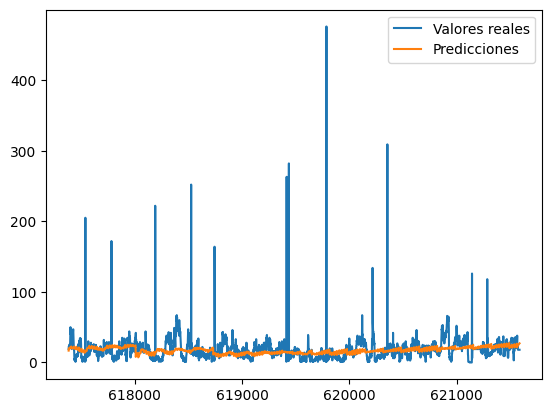

In [5]:
import pandas as pd
import json
import pickle
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv("data/raw/measurement_data.csv")
data['Measurement date'] = pd.to_datetime(data['Measurement date'])

data["hour"] = data["Measurement date"].dt.hour
data["month"] = data["Measurement date"].dt.month
data["weekday"] = data["Measurement date"].dt.weekday
data["is_weekend"] = data["weekday"].isin([5, 6]).astype(int)

stations = {
    "206": ("SO2", '2023-07-01 00:00:00', '2023-07-31 23:00:00'),
    "211": ("NO2", '2023-08-01 00:00:00', '2023-08-31 23:00:00'),
    "217": ("O3", '2023-09-01 00:00:00', '2023-09-30 23:00:00'),
    "219": ("CO", '2023-10-01 00:00:00', '2023-10-31 23:00:00'),
    "225": ("PM10", '2023-11-01 00:00:00', '2023-11-30 23:00:00'),
    "228": ("PM2.5", '2023-12-01 00:00:00', '2023-12-31 23:00:00')
}

output = {"target": {}}

for station_code, (pollutant, start_date, end_date) in stations.items():
    station_data = data[(data['Station code'] == int(station_code)) & (data[pollutant] >= 0)].copy()
    if station_data.empty:
        print(f"No hay datos suficientes para la estación {station_code} y contaminante {pollutant}")
        continue

    if pollutant == "PM10":
        station_data = station_data[(station_data[pollutant] >= 0) & (station_data[pollutant] <= 600)]

    station_data['day'] = station_data['Measurement date'].dt.day
    X = station_data[['hour', 'day', 'weekday', 'month']]
    y = station_data[pollutant]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test).flatten()
    r2 = r2_score(y_test, y_pred)
    print(f'R² para estación {station_code} y contaminante {pollutant}: {r2:.4f}')

    period_start = pd.to_datetime(start_date)
    period_end = pd.to_datetime(end_date)
    date_range = pd.date_range(start=period_start, end=period_end, freq='h')

    forecast_data = pd.DataFrame({'Measurement date': date_range})
    forecast_data['hour'] = forecast_data['Measurement date'].dt.hour
    forecast_data['day'] = forecast_data['Measurement date'].dt.day
    forecast_data['weekday'] = forecast_data['Measurement date'].dt.weekday
    forecast_data['month'] = forecast_data['Measurement date'].dt.month

    forecast_data_scaled = scaler.transform(forecast_data[['hour', 'day', 'weekday', 'month']])
    predictions = model.predict(forecast_data_scaled).flatten()

    output["target"][station_code] = {str(date): float(pred) for date, pred in zip(forecast_data['Measurement date'], predictions)}


output_filename = "predictions/predictions_task_2.json"
os.makedirs(os.path.dirname(output_filename), exist_ok=True)
with open(output_filename, 'w') as f:
    json.dump(output, f, indent=4)

print(f"Predicciones guardadas en {output_filename}")

plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, y_pred, label='Predicciones')
plt.legend()
plt.show()


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² para estación 206 y contaminante SO2: -0.2421
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² para estación 211 y contaminante NO2: 0.3282
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² para estación 217 y contaminante O3: 0.3842
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
R² para estación 219 y contaminante CO: -0.0160
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² para estación 225 y contaminante PM10: 0.2323
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\Jjaavviieerroperro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² para estación 228 y contaminante PM2.5: 0.0008
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
Predicciones guardadas en predictions/predictions_task_2.json


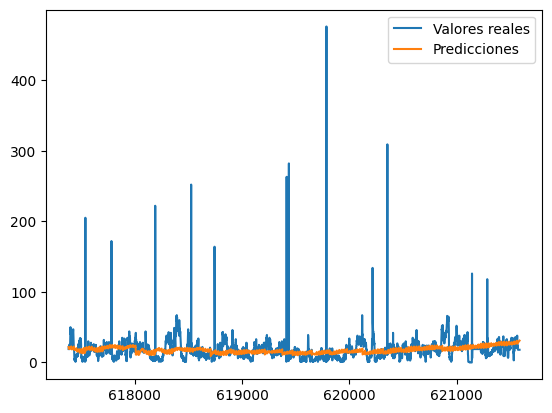

In [6]:
import pandas as pd
import json
import pickle
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv("data/raw/measurement_data.csv")
data['Measurement date'] = pd.to_datetime(data['Measurement date'])

data["hour"] = data["Measurement date"].dt.hour
data["month"] = data["Measurement date"].dt.month
data["weekday"] = data["Measurement date"].dt.weekday
data["is_weekend"] = data["weekday"].isin([5, 6]).astype(int)

stations = {
    "206": ("SO2", '2023-07-01 00:00:00', '2023-07-31 23:00:00'),
    "211": ("NO2", '2023-08-01 00:00:00', '2023-08-31 23:00:00'),
    "217": ("O3", '2023-09-01 00:00:00', '2023-09-30 23:00:00'),
    "219": ("CO", '2023-10-01 00:00:00', '2023-10-31 23:00:00'),
    "225": ("PM10", '2023-11-01 00:00:00', '2023-11-30 23:00:00'),
    "228": ("PM2.5", '2023-12-01 00:00:00', '2023-12-31 23:00:00')
}

output = {"target": {}}

for station_code, (pollutant, start_date, end_date) in stations.items():
    station_data = data[(data['Station code'] == int(station_code)) & (data[pollutant] >= 0)].copy()
    if station_data.empty:
        print(f"No hay datos suficientes para la estación {station_code} y contaminante {pollutant}")
        continue

    if pollutant == "PM10":
        station_data = station_data[(station_data[pollutant] >= 0) & (station_data[pollutant] <= 600)]

    station_data['day'] = station_data['Measurement date'].dt.day
    X = station_data[['hour', 'day', 'weekday', 'month']]
    y = station_data[pollutant]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Salida lineal para regresión
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_test).flatten()
    r2 = r2_score(y_test, y_pred)
    print(f'R² para estación {station_code} y contaminante {pollutant}: {r2:.4f}')

    period_start = pd.to_datetime(start_date)
    period_end = pd.to_datetime(end_date)
    date_range = pd.date_range(start=period_start, end=period_end, freq='h')

    forecast_data = pd.DataFrame({'Measurement date': date_range})
    forecast_data['hour'] = forecast_data['Measurement date'].dt.hour
    forecast_data['day'] = forecast_data['Measurement date'].dt.day
    forecast_data['weekday'] = forecast_data['Measurement date'].dt.weekday
    forecast_data['month'] = forecast_data['Measurement date'].dt.month

    forecast_data_scaled = scaler.transform(forecast_data[['hour', 'day', 'weekday', 'month']])
    predictions = model.predict(forecast_data_scaled).flatten()

    output["target"][station_code] = {str(date): float(pred) for date, pred in zip(forecast_data['Measurement date'], predictions)}


output_filename = "predictions/predictions_task_2.json"
os.makedirs(os.path.dirname(output_filename), exist_ok=True)
with open(output_filename, 'w') as f:
    json.dump(output, f, indent=4)

print(f"Predicciones guardadas en {output_filename}")

plt.plot(y_test.index, y_test, label='Valores reales')
plt.plot(y_test.index, y_pred, label='Predicciones')
plt.legend()
plt.show()
